# BERT Fine-tuning on IPU

This notebook will demonstrate how to fine-tune a pre-trained BERT model with PyTorch on the Graphcore IPU-POD16 system. We will use a BERT-Large model and fine-tune on the SQuADv1 Question/Answering task.

We will show how to take a BERT model written in PyTorch from the 🤗`transformers` library from HuggingFace and parallelize and run it on IPU using PopTorch.

This is an advanced tutorial: if you are new to PopTorch, we have a [PopTorch basics tutorial](https://github.com/graphcore/tutorials/tree/master/tutorials/pytorch/tut1_basics) that you can do first.


## Background

BERT fine-tuning is when you train a BERT model on a supervised learning task on a relatively small amount of data, by using starting weights obtained from pre-training on a large, generic text corpus. Pre-training of BERT requires a lot of unlabelled data (for instance all of Wikipedia + thousands of books) and a lot of compute. It is expensive and time-consuming, but after pre-training BERT will have learned an extremely good language model that can be fine-tuned on downstream tasks with small amount of labeled data, achieving great results.

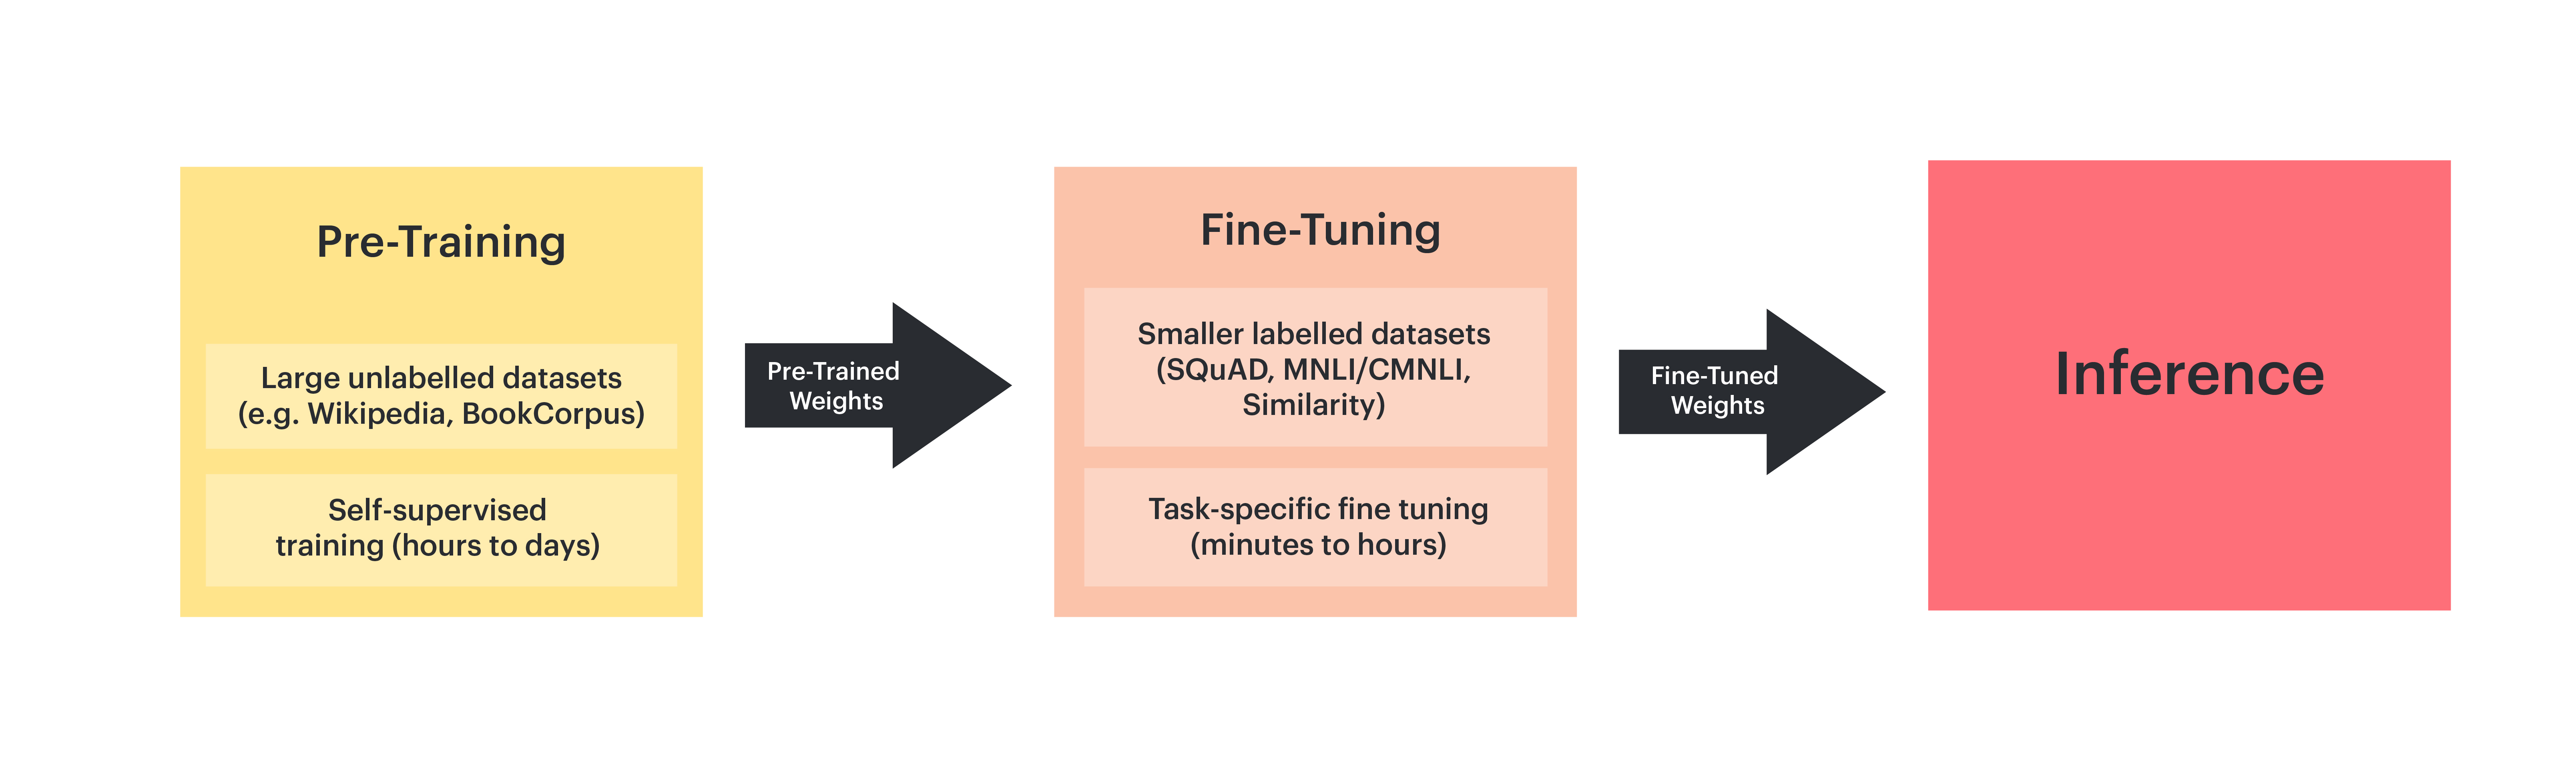

In this notebook we will fine-tune BERT (pre-trained on IPU with the Wikipedia dataset) on a question answering task called SQuAD. Then we will perform inference on the accompanying validation dataset.



In [1]:
# Import standard packages
import transformers
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
from datasets import load_dataset, load_metric
import time

# To run on IPU we import popart and poptorch packages
import popart
import poptorch

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Get the data


**What is SQuAD?**

> Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

From https://rajpurkar.github.io/SQuAD-explorer/

Basically you train a model to take a question and read a passage of text and predict the start and end positions of where that answer lies in the passage. The image below shows an example from the dataset:

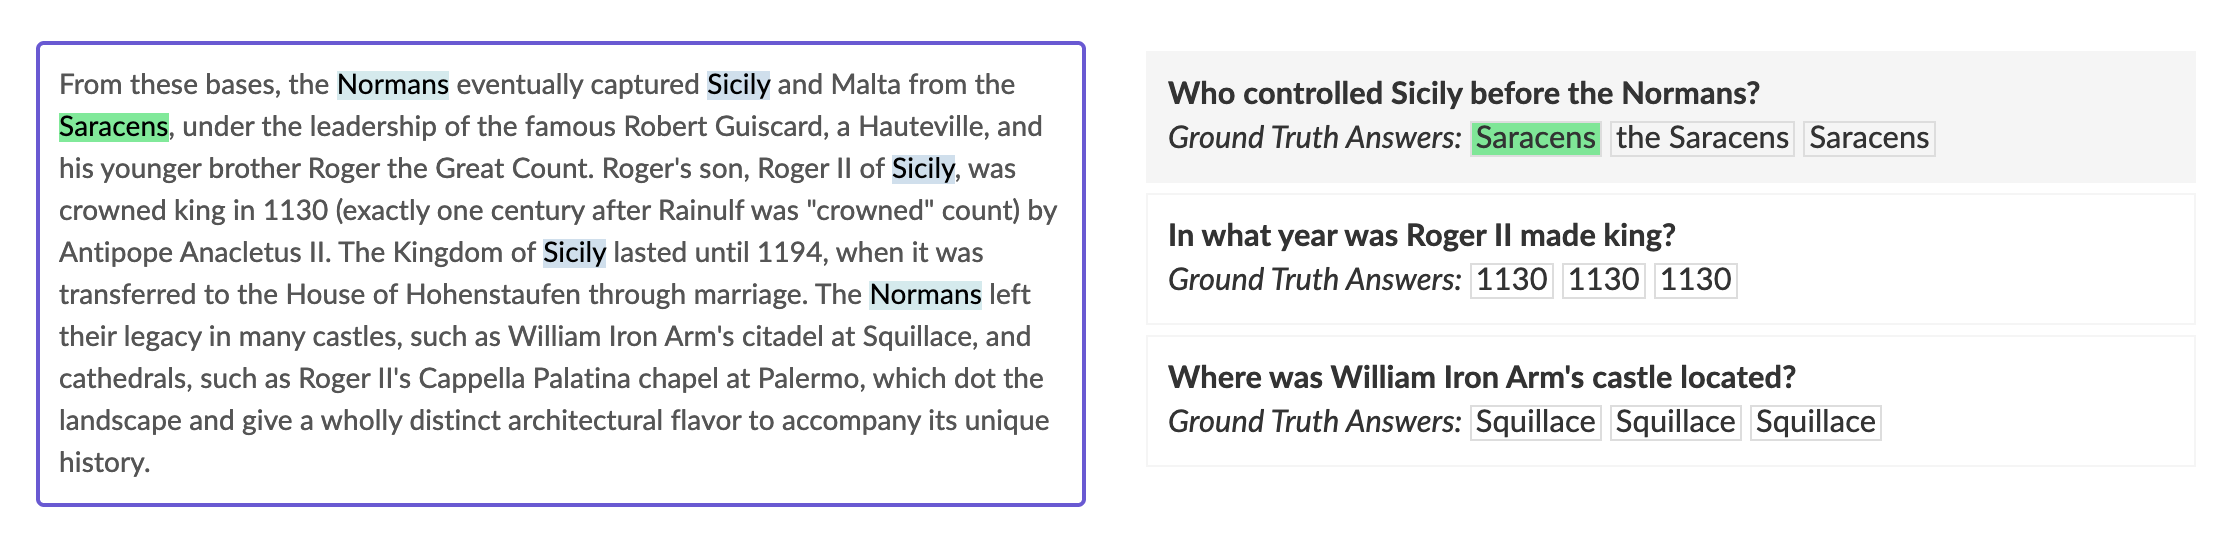

(Source: [Rajpurkar GitHub](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Normans.html))

For the case of SQuADv1 there are no unanswerable questions in the dataset.

We use the 🤗 `datasets` package to automatically download the SQuAD dataset

In [ ]:
datasets = load_dataset("squad", cache_dir="~/.torch/datasets/")

The SQuAD dataset consists of pre-defined training and validation splits.

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['answers', 'context', 'id', 'question', 'title'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['answers', 'context', 'id', 'question', 'title'],
        num_rows: 10570
    })
})

Each row in the data consists of a passage of text - `context` - a question about the passage - `question` - and the answer(s) to the question - `answers`. The latter consists of the text in the passage and the start position in the text.

Here is an example row:

In [5]:
datasets["train"][10016]

{'answers': {'text': ['middle class'], 'answer_start': [274]},
 'context': 'Institutes of technology in Venezuela were developed in the 1950s as an option for post-secondary education in technical and scientific courses, after the polytechnic French concepts. At that time, technical education was considered essential for the development of a sound middle class economy.',
 'id': '56de5ef44396321400ee2861',
 'question': 'What type of economy was technical education in Venezuela intended to support?',
 'title': 'Institute_of_technology'}

**How do we preprocess this data to train it with a deep learning model?**

We need to `tokenize` the text to turn it from words into numbers. This is done using `transformers.BertTokenizer`. Let's use this to tokenize a shortened version of the example above:

In [6]:
from squad_preprocessing import tokenizer

In [7]:
example = {"context": "Institutes of technology in Venezuela were developed in the 1950s",
           "question": "When were Institutes of technology developed?"}
tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=32,
        stride=16,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

In [8]:
tokenized_example.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

Let's look at the `input_ids`:

In [9]:
tokenized_example.input_ids[0]

[101,
 2043,
 2020,
 12769,
 1997,
 2974,
 2764,
 1029,
 102,
 12769,
 1997,
 2974,
 1999,
 8326,
 2020,
 2764,
 1999,
 1996,
 4856,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [10]:
tokenizer.decode(tokenized_example.input_ids[0])

'[CLS] when were institutes of technology developed? [SEP] institutes of technology in venezuela were developed in the 1950s [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

As you can see in the decoded version, the question is placed at the start followed by a `[SEP]` token, then the context, followed by padding if required.

In [11]:
from squad_preprocessing import prepare_train_features, prepare_validation_features, tokenizer

In [ ]:
train_dataset = datasets["train"].map(
    prepare_train_features,
    batched=True,
    num_proc=1,
    remove_columns=datasets["train"].column_names,
    load_from_cache_file=True,
)

# Create validation features from dataset
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    num_proc=1,
    remove_columns=datasets["validation"].column_names,
    load_from_cache_file=True,
)

## 2. Get the Model and Parallelize on IPU-POD16

We run the model on IPU using both **pipelining** and **data parallelism** in order to maximise hardware use.

### Parallelism through pipelining

The model layers are split over 8 IPUs. We then use [*pipeline parallelism*](https://docs.graphcore.ai/projects/tf-model-parallelism/en/latest/pipelining.html) over the IPUs with gradient accumulation. We subdivide the compute batch into micro-batches that pass through the pipeline in the forward pass and then come back again in the backwards pass, accumulating gradients for the parameters as they go.

A complete pipeline step has a ramp-up phase the start and a ramp-down phase at the end. Increasing the gradient accumulation factor, increases the total batch size and also increases the pipeline efficiency, and therefore throughput, because the proportion of time in ramp-up/down phases will be reduced. 

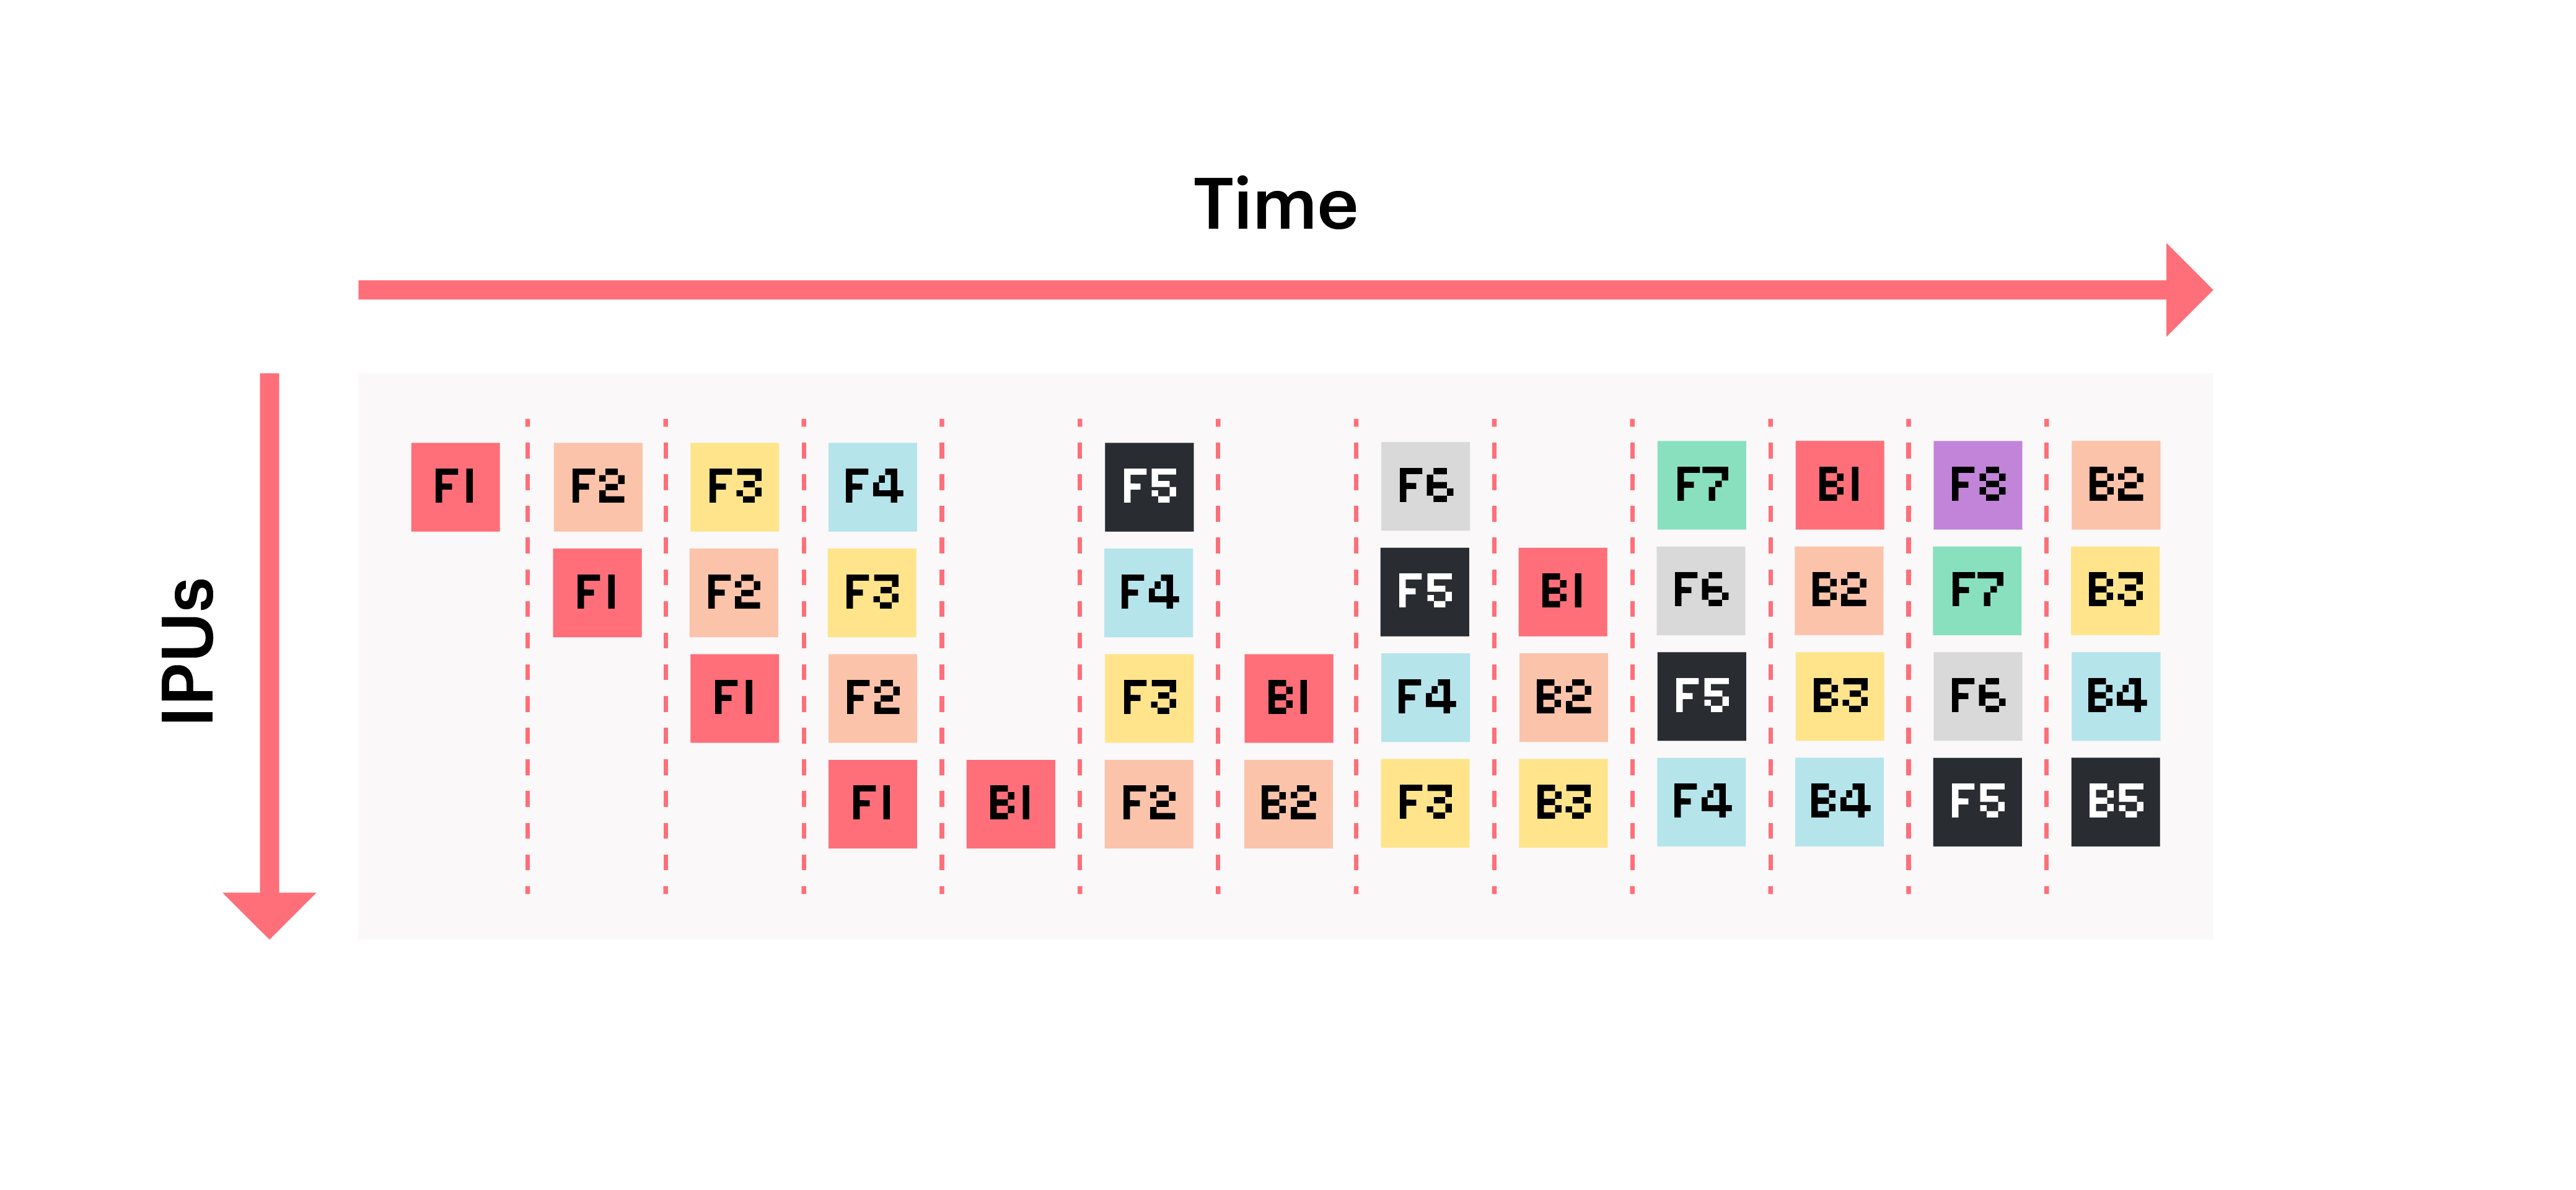

### Partitioning the Model

BERT Large has 24 transformer layers, which we will split over our 8 IPUs. The embeddings, MLM projection layers, and the first 2 transformer layers sit on IPU0, the following 6 IPUs have 3 transformer layers each, and the last IPU has 4.

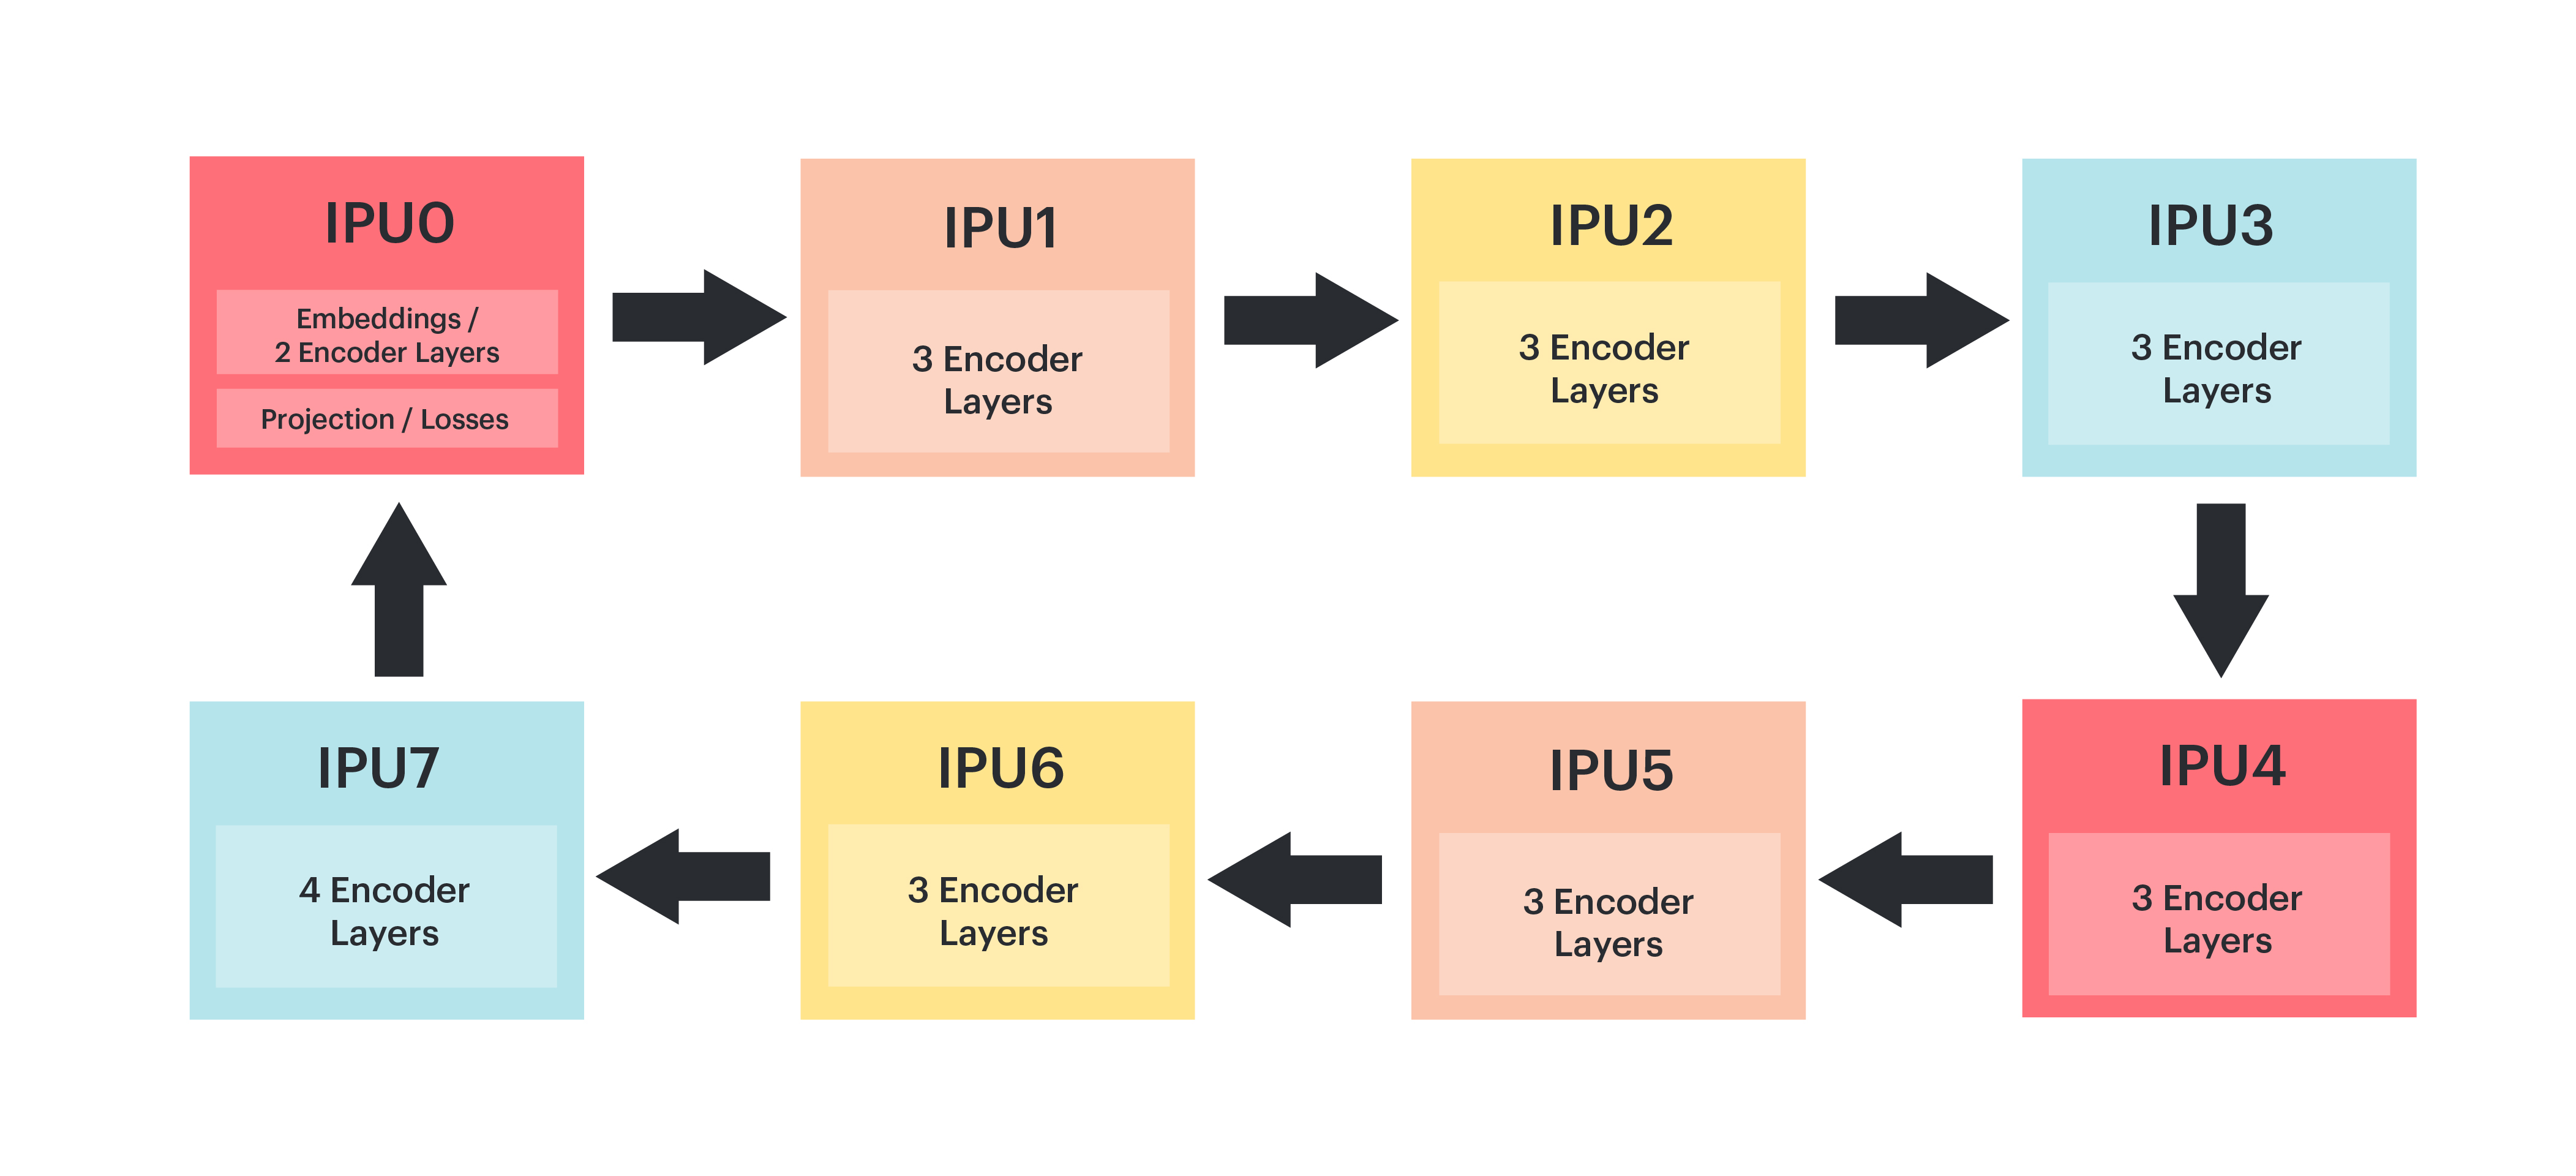


### Data Parallelism

Ann IPU-POD16 contains 16 IPUs and our pipeline is 8 IPUs long. We can therefore replicate the pipeline, feeding two different micro-batches to the device, which doubles the effective mini-batch size. We call this configuration a "2x8 pipeline".


### Recomputation Checkpoints

We can make more efficient use of the valuable In-Processor-Memory by saving only selected activation inputs and recomputing the rest. This lets us optimise on memory savings (by not storing all activations) vs FLOP expenditure (by not having to recompute all activations). 
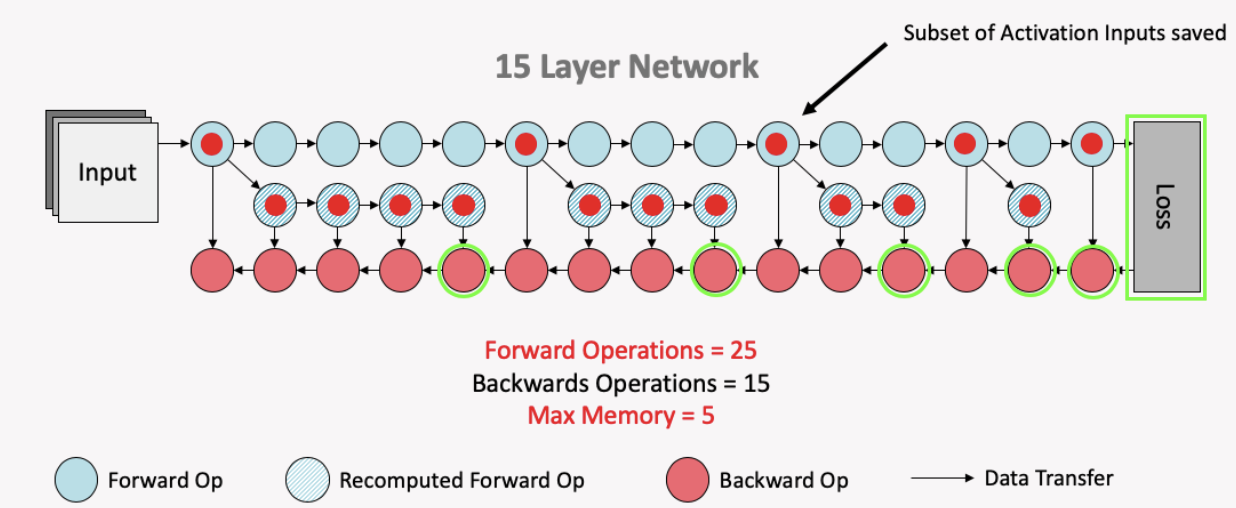
Source: [TensorFlow Model Parallelism: Recomputation](https://docs.graphcore.ai/projects/tf-model-parallelism/en/latest/pipelining.html#recomputation)

Checkpoints are automatically placed between each pipeline stage. In addition to these automatic checkpoints, we are adding one at the end of every transformer layer, which leads to better performance.

### Replicated Tensor Sharding of Optimizer State

As we are using multiple replicas (2 here), we can also distribute our optimizer state to reduce local memory usage, a method called [On-chip Replicated Tensor Sharding (RTS)](https://docs.graphcore.ai/projects/graphcore-glossary/en/latest/index.html#term-Replicated-tensor-sharding).

> To further improve memory availability we also have the option to store tensors in the POD-IPU16 Streaming Memory at the cost of increased communications.

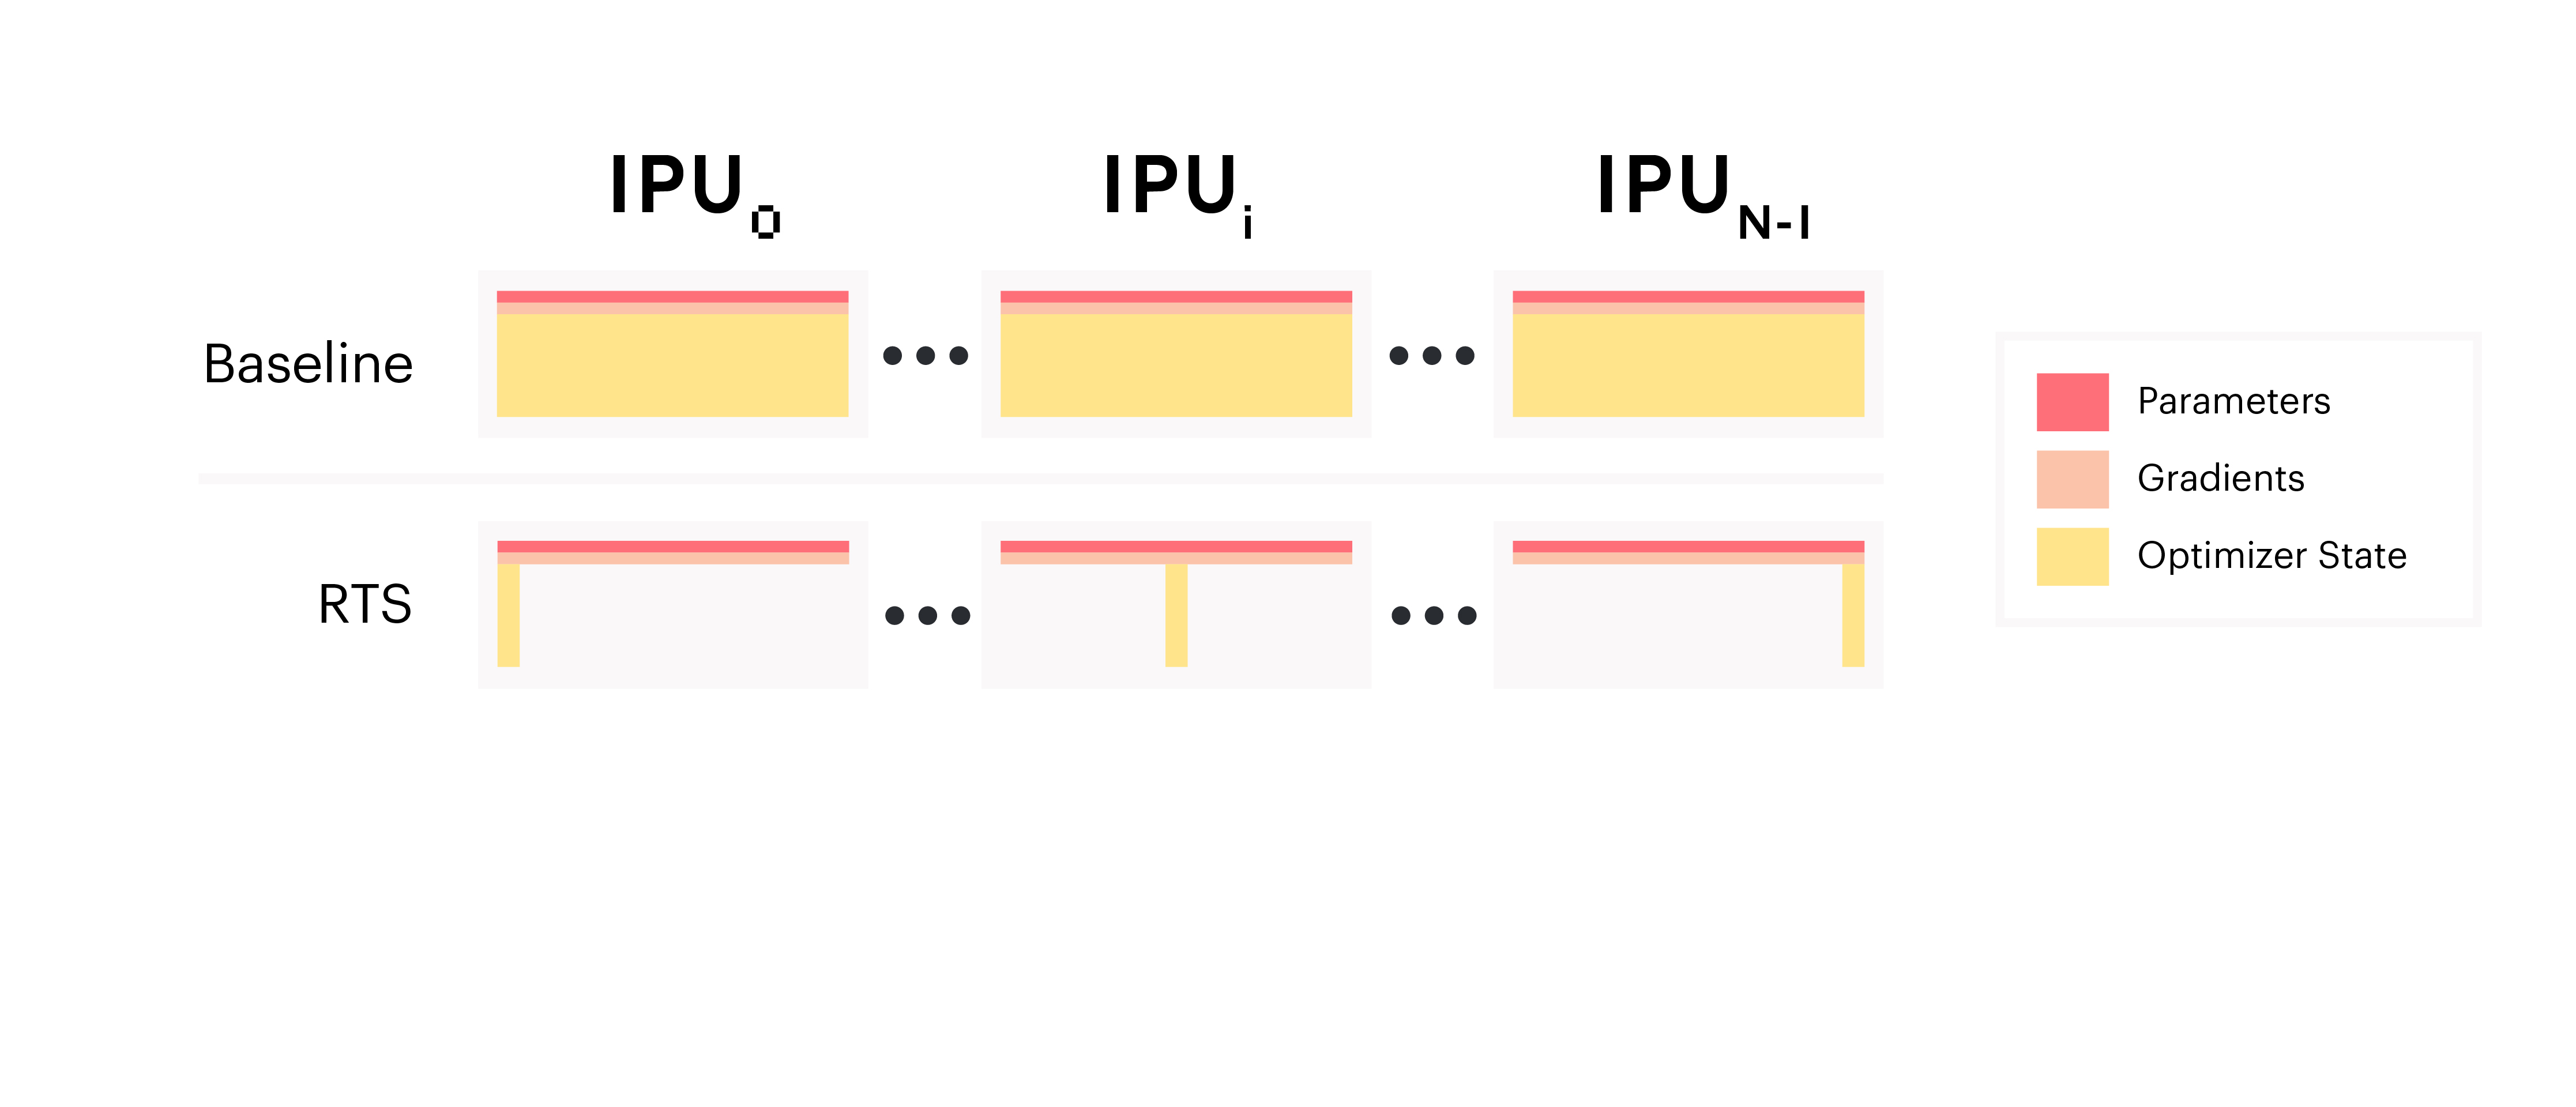

In [13]:
# This function marks a PyTorch layer as a recomputation checkpoint
def checkpoint_outputs(module: nn.Module):
    """Annotates the output of a module to be checkpointed instead of
        recomputed"""
    def recompute_outputs(module, inputs, outputs):
        return tuple(poptorch.recomputationCheckpoint(y) for y in outputs)
    module.register_forward_hook(recompute_outputs)

In [14]:
def get_layer_ipu(layers_per_ipu):
    # List of the IPU Id for each encoder layer
    layer_ipu = []
    for ipu, n_layers in enumerate(layers_per_ipu):
        layer_ipu += [ipu] * n_layers
    return layer_ipu


# Subclass the HuggingFace BERTForQuestionAnswering model
class PipelinedBertForQuestionAnswering(transformers.BertForQuestionAnswering):
    def parallelize(self, ipu_config):
        layer_ipu = get_layer_ipu(ipu_config["layers_per_ipu"])
        print("-------------------- Device Allocation --------------------")
        print("Embedding  --> IPU 0")
        self.bert.embeddings = poptorch.BeginBlock(self.bert.embeddings, "Embedding", ipu_id=0)

        for index, layer in enumerate(self.bert.encoder.layer):
            ipu = layer_ipu[index]
            if index != self.config.num_hidden_layers - 1:
                checkpoint_outputs(layer)
            self.bert.encoder.layer[index] = poptorch.BeginBlock(layer, f"Encoder{index}", ipu_id=ipu)
            print(f"Encoder {index:<2} --> IPU {ipu}")

        print(f"QA Outputs --> IPU {ipu}")
        self.qa_outputs = poptorch.BeginBlock(self.qa_outputs, "QA Outputs", ipu_id=ipu)
        return self

    # Model training loop is entirely running on IPU so we add Loss computation here
    def forward(self, input_ids, attention_mask, token_type_ids, start_positions=None, end_positions=None):
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "start_positions": start_positions,
            "end_positions": end_positions
        }
        output = super().forward(**inputs)
        if self.training:
            final_loss = poptorch.identity_loss(output.loss, reduction="none")
            return final_loss, output.start_logits, output.end_logits
        else:
            return output.start_logits, output.end_logits

In [15]:
# BERT-Large configuration
config = transformers.BertConfig(hidden_size=1024,
                                 intermediate_size=1024*4,
                                 num_hidden_layers=24,
                                 num_attention_heads=16,
                                 hidden_dropout_prob=0.15,
                                 attention_probs_dropout_prob=0.1,
                                 layer_norm_eps=1e-6)

Model is still on CPU at this point. We can use `from_pretrained` to load pretrained checkpoints from the HuggingFace Hub.

In [16]:
model = PipelinedBertForQuestionAnswering.from_pretrained("Graphcore/bert-large-uncased", config=config)

Some weights of the model checkpoint at Graphcore/bert-large-uncased were not used when initializing PipelinedBertForQuestionAnswering: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing PipelinedBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PipelinedBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PipelinedBertForQuestionAnswering were not initialized f

We can now set up our pipelined execution by specifying which layers to put on each IPU, and passing it to the `parallelize` method that we defined above.

We also call the `.half()` method to cast all the model weights to half-precision (FP16). The `.train()` sets the PyTorch model to training mode.

If you unfamiliar with training in half precision on IPU, then we have a tutorial on [Half and Mixed Precision in Poptorch](https://github.com/graphcore/tutorials/tree/master/tutorials/pytorch/tut3_mixed_precision).

In [17]:
ipu_config = {"layers_per_ipu": [2,3,3,3,3,3,3,4],
              "recompute_checkpoint_every_layer": True}

model.parallelize(ipu_config).half().train();

-------------------- Device Allocation --------------------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 1
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 2
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 3
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 4
Encoder 12 --> IPU 4
Encoder 13 --> IPU 4
Encoder 14 --> IPU 5
Encoder 15 --> IPU 5
Encoder 16 --> IPU 5
Encoder 17 --> IPU 6
Encoder 18 --> IPU 6
Encoder 19 --> IPU 6
Encoder 20 --> IPU 7
Encoder 21 --> IPU 7
Encoder 22 --> IPU 7
Encoder 23 --> IPU 7
QA Outputs --> IPU 7


## 3. Runtime Configuration

We will use a global batch size of 256 divided as such:
- Micro batch size of 2 (the size of the batch passed to each replica)
- Replication factor of 2 (the number of data parallel replicas, see the [Data Parallelism](#Data-Parallelism) section)
- Gradient accumulation of 64 (the number of forward/backward passes performed per weight update)

In [18]:
global_batch_size = 256
micro_batch_size = 2
replication_factor = 2
gradient_accumulation = int(global_batch_size / micro_batch_size / replication_factor)

`device_iterations` is the number of batches the device should run before returning to the user. Increasing `device_iterations` can more efficient because the loop runs on the IPU directly, reducing overhead costs. Please see the [documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html?highlight=device%20iterations#poptorch-options-deviceiterations) for more information.

In [19]:
device_iterations = 1
samples_per_iteration = global_batch_size * device_iterations

In [20]:
num_epochs = 3

We will now set the IPU configuration options.

In [21]:
def ipu_training_options(gradient_accumulation, replication_factor, device_iterations):
    opts = poptorch.Options()
    opts.randomSeed(12345)
    opts.deviceIterations(device_iterations)
    
    # Use Pipelined Execution
    opts.setExecutionStrategy(
        poptorch.PipelinedExecution(poptorch.AutoStage.AutoIncrement))

    # Use Stochastic Rounding
    opts.Precision.enableStochasticRounding(True)
    
    # Half precision partials for matmuls and convolutions
    opts.Precision.setPartialsType(torch.float16)
    
    opts.replicationFactor(replication_factor)
    
    opts.Training.gradientAccumulation(gradient_accumulation)
    
    # Return all results from IPU to host
    opts.anchorMode(poptorch.AnchorMode.All)
    
    # Cache compiled executable to disk
    opts.enableExecutableCaching("./exe_cache")

    # On-chip Replicated Tensor Sharding of Optimizer State
    opts.TensorLocations.setOptimizerLocation(
        poptorch.TensorLocationSettings()
        # Optimizer state lives on IPU
        .useOnChipStorage(True)
        # Optimizer state sharded between replicas with zero-redundancy
        .useReplicatedTensorSharding(True))

    # Available Transcient Memory For matmuls and convolutions operations
    opts.setAvailableMemoryProportion({f"IPU{i}": mp
                                       for i, mp in enumerate([0.08,0.28,0.32,0.32,0.36,0.38,0.4,0.32])})
    
    ## Advanced performance options ##

    # Only stream needed tensors back to host
    opts._Popart.set("disableGradAccumulationTensorStreams", True)

    # Copy inputs and outputs as they are needed
    opts._Popart.set("subgraphCopyingStrategy", int(popart.SubgraphCopyingStrategy.JustInTime))

    # Parallelize optimizer step update
    opts._Popart.set("accumulateOuterFragmentSettings.schedule",
                     int(popart.AccumulateOuterFragmentSchedule.OverlapMemoryOptimized))
    opts._Popart.set("accumulateOuterFragmentSettings.excludedVirtualGraphs", ["0"])
    return opts

In [22]:
train_opts = ipu_training_options(gradient_accumulation, replication_factor, device_iterations)

## 4. Training Loop

In [23]:
from squad_preprocessing import PadCollate

In [24]:
sequence_length = 384

We use the `poptorch.Dataloader` which is a drop-in replacement of `torch.Dataloader`, extending it with IPU specific options and asynchronous execution.

Another small difference is the use of the `PadCollate` function. If `drop_last` option is false in a `DataLoader`, you may end up with a *remainder mini-batch* at the end of the epoch that is smaller than the other mini-batches. 

For a compiled device like IPU that would require a recompilation of the execution graph for that one mini-batch. In order to not lose any training examples, we can pad the remainder mini-batch with zeros and set the target values to a special value which will set the loss to 0 in those cases so they don't affect training. This way we have consistent mini-batch sizes and we can train on all the data.

More information can be found in the [`poptorch.DataLoader` documentation.](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html#efficient-data-batching) and also in our [tutorial on efficient data loading.](https://github.com/graphcore/tutorials/tree/master/tutorials/pytorch/tut2_efficient_data_loading)

In [25]:
train_dl = poptorch.DataLoader(train_opts,
                               train_dataset,
                               batch_size=micro_batch_size,
                               shuffle=True,
                               drop_last=False,
                               collate_fn=PadCollate(global_batch_size,
                                                     {"input_ids": 0,
                                                      "attention_mask": 0,
                                                      "token_type_ids": 0,
                                                      "start_positions": sequence_length,
                                                      "end_positions": sequence_length}))

[21:54:09.990] [poptorch::python] [warning] The number of elements in the dataset (88524) is not divisible by the number of elements processed per step (256) and drop_last=False. The last tensor will have a batch size of 204. To avoid having to handle this special case switch to drop_last=True


We will use poptorch's version of the `AdamW` optimizer, its interface is the same as `AdamW` from `torch.optim`, but with some extra options.

Please see the [`poptorch.optim` documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/overview.html#optimizers) for more information.

In [26]:
def get_optimizer(model):
    # Do not apply weight_decay for one-dimensional parameters
    regularized_params = []
    non_regularized_params = []
    for param in model.parameters():
        if param.requires_grad:
            if len(param.shape) == 1:
                non_regularized_params.append(param)
            else:
                regularized_params.append(param)

    params = [
        {"params": regularized_params, "weight_decay": 0.01},
        {"params": non_regularized_params, "weight_decay": 0}
    ]
    optimizer = poptorch.optim.AdamW(params,
                                     lr=1e-4,
                                     weight_decay=0,
                                     eps=1e-6,
                                     bias_correction=True,
                                     loss_scaling=64,
                                     first_order_momentum_accum_type=torch.float16,
                                     accum_type=torch.float16)
    return optimizer

In [27]:
optimizer = get_optimizer(model)

Now we create the function that will train our model on the IPU, then run it:

In [28]:
def trainer(model, opts, optimizer, train_dl, num_epochs):
    num_steps = num_epochs * len(train_dl)
    lr_scheduler = transformers.get_scheduler("cosine", optimizer, 0.1 * num_steps, num_steps)
    
    # Wrap the pytorch model with poptorch.trainingModel
    training_model = poptorch.trainingModel(model, train_opts, optimizer)
    
    # Compile model or load from executable cache
    batch = next(iter(train_dl))
    outputs = training_model.compile(batch["input_ids"],
                                     batch["attention_mask"],
                                     batch["token_type_ids"],
                                     batch["start_positions"],
                                     batch["end_positions"])
    # Training Loop
    for epoch in trange(num_epochs, desc="Epochs"):
        train_iter = tqdm(train_dl)
        for step, batch in enumerate(train_iter):
            start_step = time.perf_counter()
            
            # This completes a forward+backward+weight update step
            outputs = training_model(batch["input_ids"],
                                     batch["attention_mask"],
                                     batch["token_type_ids"],
                                     batch["start_positions"],
                                     batch["end_positions"])

            # Update the LR and update the poptorch optimizer
            lr_scheduler.step()
            training_model.setOptimizer(optimizer)
            step_length = time.perf_counter() - start_step
            step_throughput = samples_per_iteration / step_length
            loss = outputs[0].mean().item()
            train_iter.set_description(
                f"Epoch: {epoch} - "
                f"Step: {step} - "
                f"Loss: {loss:3.3f} - "
                f"Throughput: {step_throughput:3.3f} seq/s")
    
    # Detach the model from the device once training is over so the device is free to be reused for validation
    training_model.detachFromDevice()

In [29]:
trainer(model, train_opts, optimizer, train_dl, num_epochs)

Graph compilation: 100%|██████████| 100/100 [00:12<00:00]


After training, we save the model weights to disk.

In [30]:
model.save_pretrained("checkpoints/squad_large_2x8")

## 5. Validation

We will now take the model we just trained on the training data and run validation on the SQuAD validation dataset. The model will run on a 2-IPU pipeline that we will replicate 8 times.

In [31]:
from datasets import load_metric
from squad_preprocessing import postprocess_qa_predictions

In [32]:
micro_batch_size = 6
replication_factor = 8
global_batch_size = micro_batch_size * replication_factor
device_iterations = 2
samples_per_iteration = global_batch_size * device_iterations

In [33]:
def ipu_validation_options(replication_factor, device_iterations):
    opts = poptorch.Options()
    opts.randomSeed(42)
    opts.deviceIterations(device_iterations)

    opts.setExecutionStrategy(
        poptorch.PipelinedExecution(poptorch.AutoStage.AutoIncrement))

    # Stochastic rounding not needed for validation
    opts.Precision.enableStochasticRounding(False) 

    # Half precision partials for matmuls and convolutions
    opts.Precision.setPartialsType(torch.float16)
    
    opts.replicationFactor(replication_factor)

    # No gradient accumulation for Inference
    opts.Training.gradientAccumulation(1)
    
    # Return all results from IPU
    opts.anchorMode(poptorch.AnchorMode.All)
    
    # Cache compiled executable to disk
    opts.enableExecutableCaching("./exe_cache")
    
    return opts

In [34]:
val_opts = ipu_validation_options(replication_factor, device_iterations)

In [35]:
ipu_config = {"layers_per_ipu": [11, 13],
              "recompute_checkpoint_every_layer": False}

Let's load the model weights we previously trained from disk:

In [36]:
model = PipelinedBertForQuestionAnswering.from_pretrained("checkpoints/squad_large_2x8")

We cast the model weights to half precision (FP16) and set the model to evaluation mode:

In [37]:
model.parallelize(ipu_config).half().eval();

-------------------- Device Allocation --------------------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 0
Encoder 4  --> IPU 0
Encoder 5  --> IPU 0
Encoder 6  --> IPU 0
Encoder 7  --> IPU 0
Encoder 8  --> IPU 0
Encoder 9  --> IPU 0
Encoder 10 --> IPU 0
Encoder 11 --> IPU 1
Encoder 12 --> IPU 1
Encoder 13 --> IPU 1
Encoder 14 --> IPU 1
Encoder 15 --> IPU 1
Encoder 16 --> IPU 1
Encoder 17 --> IPU 1
Encoder 18 --> IPU 1
Encoder 19 --> IPU 1
Encoder 20 --> IPU 1
Encoder 21 --> IPU 1
Encoder 22 --> IPU 1
Encoder 23 --> IPU 1
QA Outputs --> IPU 1


In [38]:
val_dl = poptorch.DataLoader(val_opts,
                             validation_features.remove_columns(
                                 ['example_id', 'offset_mapping']),
                             batch_size=micro_batch_size,
                             shuffle=False,
                             drop_last=False,
                             collate_fn=PadCollate(global_batch_size,
                                                   {"input_ids": 0,
                                                    "attention_mask": 0,
                                                    "token_type_ids": 0}))

[22:06:00.467] [poptorch::python] [warning] The number of elements in the dataset (10784) is not divisible by the number of elements processed per step (96) and drop_last=False. The last tensor will have a batch size of 32. To avoid having to handle this special case switch to drop_last=True


In [39]:
def validator(model, opts, val_dl):    
    # Wrap the pytorch model with poptorch.inferenceModel for inference
    inference_model = poptorch.inferenceModel(model, opts)
    
    raw_predictions = [[], []]
    val_iter = tqdm(val_dl, desc="Validation")
    for step, batch in enumerate(val_iter):
        start_step = time.perf_counter()
        outputs = inference_model(batch["input_ids"],
                                  batch["attention_mask"],
                                  batch["token_type_ids"])
        step_length = time.perf_counter() - start_step
        step_throughput = samples_per_iteration / step_length
        raw_predictions[0].append(outputs[0])
        raw_predictions[1].append(outputs[1])
        val_iter.set_description(
            f"Step: {step} - throughput: {step_throughput:3.3f} samples/s")
    inference_model.detachFromDevice()
    
    raw_predictions[0] = torch.vstack(raw_predictions[0]).float().numpy()
    raw_predictions[1] = torch.vstack(raw_predictions[1]).float().numpy()
    return raw_predictions

We loop over all the validation data examples and get the `raw_predictions` for the start and end positions of where the answer to the question lies in the text passage for each one.

In [40]:
raw_predictions = validator(model, val_opts, val_dl)


Graph compilation: 100%|██████████| 100/100 [00:06<00:00]


We now post-processed the raw predictions to the question answering task to get the best prediction that's valid for each one.

In [41]:
final_predictions = postprocess_qa_predictions(datasets["validation"],
                                               validation_features,
                                               raw_predictions)

Post-processing 10570 example predictions split into 10784 features.


In [42]:
metric = load_metric("squad")
formatted_predictions = [{"id": k, "prediction_text": v}
                         for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]}
              for ex in datasets["validation"]]
metrics = metric.compute(predictions=formatted_predictions, references=references)
print(metrics)

{'exact_match': 84.76821192052981, 'f1': 91.16387884333797}


We obtained here a good validation score for SQuADv1.

| BERT-Large                             | Exact Match | F1 Score |
|----------------------------------------|:-----------:|:--------:|
| Reference (Devling et al. 2018)        | 84.1        | 90.9     |
| IPU-POD16 with IPU pre-trained weights | 84.7        | 91.1     |

## 6. Inference

We can now use our fine-tuned model to answer questions. Let's start by defining a task:

In [43]:
# Define task
question = "What speed-up can one expect from using sequence packing for training BERT on IPU?"
answer_text = "We find that at sequence length 512 padding tokens represent in excess of 50% of the Wikipedia" \
              "dataset used for pretraining BERT (Bidirectional Encoder Representations from Transformers)." \
             "Therefore by removing all padding we achieve a 2x speed-up in terms of sequences/sec." \
             "To exploit this characteristic of the dataset," \
             "we develop and contrast two deterministic packing algorithms."

Let's get the model inputs ready and create our model. We'll import the weights from the pre-trained, fine-tuned BERT model from the previous sections:

In [44]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_encoding = tokenizer.encode_plus((question, answer_text))

# Extract inputs, add batch dimension
input_tensor = torch.tensor(input_encoding["input_ids"]).unsqueeze(0)
attention_tensor= torch.tensor(input_encoding["attention_mask"]).unsqueeze(0)
token_types=torch.tensor(input_encoding["token_type_ids"]).unsqueeze(0)
    
# Get model and load the fine-tuned weights
model = transformers.BertForQuestionAnswering.from_pretrained("checkpoints/squad_large_2x8")

Optionally, instead of using the fine-tuned weights we saved in the previous section, you can download fine-tuned weights from the [Graphcore organisation on the HuggingFace Model Hub](https://huggingface.co/Graphcore). 

In [ ]:
# model = transformers.BertForQuestionAnswering.from_pretrained("Graphcore/bert-large-uncased-squad11")

We can now solve the task and print the answer to the question:

In [45]:
# Solve task
outputs = model(input_tensor, attention_tensor, token_types)

# Extract answer
answer_start, answer_stop = outputs.start_logits.argmax(), outputs.end_logits.argmax()
answer_ids = input_tensor.squeeze()[answer_start:answer_stop + 1]
answer_tokens = tokenizer.convert_ids_to_tokens(answer_ids, skip_special_tokens=True)
answer = tokenizer.convert_tokens_to_string(answer_tokens)

# Print results
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What speed-up can one expect from using sequence packing for training BERT on IPU?
Answer: 2x


**That's it for today folks. We learned how to fine-tune a BERT-Large model on the SQuADv1.1 dataset to get SOTA performance. Our model can now answer questions.**